<a href="https://colab.research.google.com/github/AfterALLo/Computer-Vision-Project/blob/main/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Identifying Wild Mushrooms using Object Setection <b> </h1></center>

Importing required Libraries

In [ ]:
!pip install tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Checking Missing Files

Checking the folders if every image file has a corresponding label file

In [1]:
from pathlib import Path

DATA_DIR = Path(r"C:\Users\User\Desktop\Mushrooms-yolov5.v1i.yolov8")

assert (DATA_DIR / "train/images").exists(), "train/images not found"
assert (DATA_DIR / "train/labels").exists(), "train/labels not found"
assert (DATA_DIR / "valid/images").exists(),   "valid/images not found"
assert (DATA_DIR / "valid/labels").exists(),   "valid/labels not found"

if not (DATA_DIR / "test/images").exists():
    print("Note: test/ missing — validation will still work.")

In [2]:
image_dir_val = DATA_DIR / "valid/images"
label_dir_val = DATA_DIR / "valid/labels"

# Gather image and label files
image_files_val = list(image_dir_val.glob("*.*"))
label_files_val = list(label_dir_val.glob("*.txt"))

# Extract stem names (file name without extension)
image_stems = {img.stem for img in image_files_val}
label_stems = {lbl.stem for lbl in label_files_val}

# Find mismatches
missing_labels = image_stems - label_stems
missing_images = label_stems - image_stems

print(f"Validation set:")
print(len(image_files_val), "images  =", len(label_files_val), "labels")
print(f"Missing label files: {len(missing_labels)}")
print(f"Missing image files: {len(missing_images)}")

if missing_labels:
    print("  Example missing label(s):", list(missing_labels)[:5])
if missing_images:
    print("  Example missing image(s):", list(missing_images)[:5])

Validation set:
798 images  = 798 labels
Missing label files: 0
Missing image files: 0


In [3]:
# Find extra files in each folder

image_files_train = {p.stem for p in (DATA_DIR / "train/images").glob("*.*")}
label_files_train = {p.stem for p in (DATA_DIR / "train/labels").glob("*.txt")}

#TRAINING DATA
extra_images_train = image_files_train - label_files_train
extra_labels_train = label_files_train - image_files_train

# Output the results
print(f"Training Extra images (without corresponding labels): {extra_images_train}")
print(f"Training Extra labels (without corresponding images): {extra_labels_train}")

#VALIDATION DATA
image_files_val = {p.stem for p in (DATA_DIR / "val/images").glob("*.*")}
label_files_val = {p.stem for p in (DATA_DIR / "val/labels").glob("*.txt")}

extra_images_val = image_files_val - label_files_val
extra_labels_val = label_files_val - image_files_val

# Output the results
print(f"Validation Extra images (without corresponding labels): {extra_images_val}")
print(f"Validation Extra labels (without corresponding images): {extra_labels_val}")

Training Extra images (without corresponding labels): set()
Training Extra labels (without corresponding images): set()
Validation Extra images (without corresponding labels): set()
Validation Extra labels (without corresponding images): set()


Removing from the dataset:

In [4]:
for file in extra_images_train:
     os.remove(os.path.join(image_dir, "train", file + '.jpg'))

for file in extra_images_val:
     os.remove(os.path.join(image_dir, "val", file + '.jpg'))

# Custom object detection using YOLO

Import YOLO model

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.223  Python-3.11.0 torch-2.10.0.dev20251021+cu128 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
Setup complete  (16 CPUs, 31.1 GB RAM, 365.6/930.6 GB disk)


In [ ]:
from ultralytics import YOLO

## Training YOLO

We used small pretrained (on COCO dataset) model of YOLOv8

In [ ]:
model = YOLO('yolov8s.pt') # pretrained model

In [ ]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [1]:
%%writefile config.yaml
path: C:/Users/User/Desktop/Mushrooms-yolov5.v1i.yolov8

train: C:/Users/User/Desktop/Mushrooms-yolov5.v1i.yolov8/train/images
val: C:/Users/User/Desktop/Mushrooms-yolov5.v1i.yolov8/valid/images
test: C:/Users/User/Desktop/Mushrooms-yolov5.v1i.yolov8/test/images
test2: C:/Users/User/Desktop/Mushrooms-yolov5.v1i.yolov8/test_customer/images

# Classes
nc: 21

# Class names
names: [
  'Agaricus bisporus',
  'Agaricus blazei Murill',
  'Agrocybe aegerita',
  'Armillaria mellea',
  'Auricularia auricula',
  'Boletus',
  'Cantharellus cibarius',
  'Clitocybe maxima',
  'Collybia albuminosa',
  'Coprinus comatus',
  'Cordyceps militaris',
  'Dictyophora indusiate',
  'Flammulina velutiper',
  'Hericium erinaceus',
  'Hypsizygus marmoreus',
  'Lentinus edodes',
  'Morchella esculenta',
  'Pleurotus citrinopileatus',
  'Pleurotus cystidiosus',
  'Pleurotus eryngii',
  'Pleurotus ostreatus'
]

Writing config.yaml


In [ ]:
model.train(data="config.yaml",epochs=15,patience=5,batch=16, lr0=0.001,imgsz=640)

Ultralytics 8.3.223  Python-3.11.0 torch-2.10.0.dev20251021+cu128 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=config.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train26, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000261887C2E50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104,

## Evaluation Metrics

In [ ]:
metrics = model.val()
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics 8.3.218  Python-3.11.0 torch-2.10.0.dev20251021+cu128 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
Model summary (fused): 72 layers, 11,133,711 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 849.3324.8 MB/s, size: 43.6 KB)
val: Scanning C:\Users\User\Desktop\Mushrooms-yolov5.v1i.yolov8\valid\labels.cache... 798 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 798/798  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 10.8it/s 4.6s
                   all        798       1801      0.747      0.684      0.748      0.595
     Agaricus bisporus         32        105       0.78      0.705      0.791      0.674
Agaricus blazei Murill         27         66      0.581      0.485      0.519      0.364
     Agrocybe aegerita         35         43      0.726      0.677      0.642       0.54
     Armillaria mellea         39         70      0.579      0.557      0.637      0.5

np.float64(0.6843447551851147)

Confusion matrix:

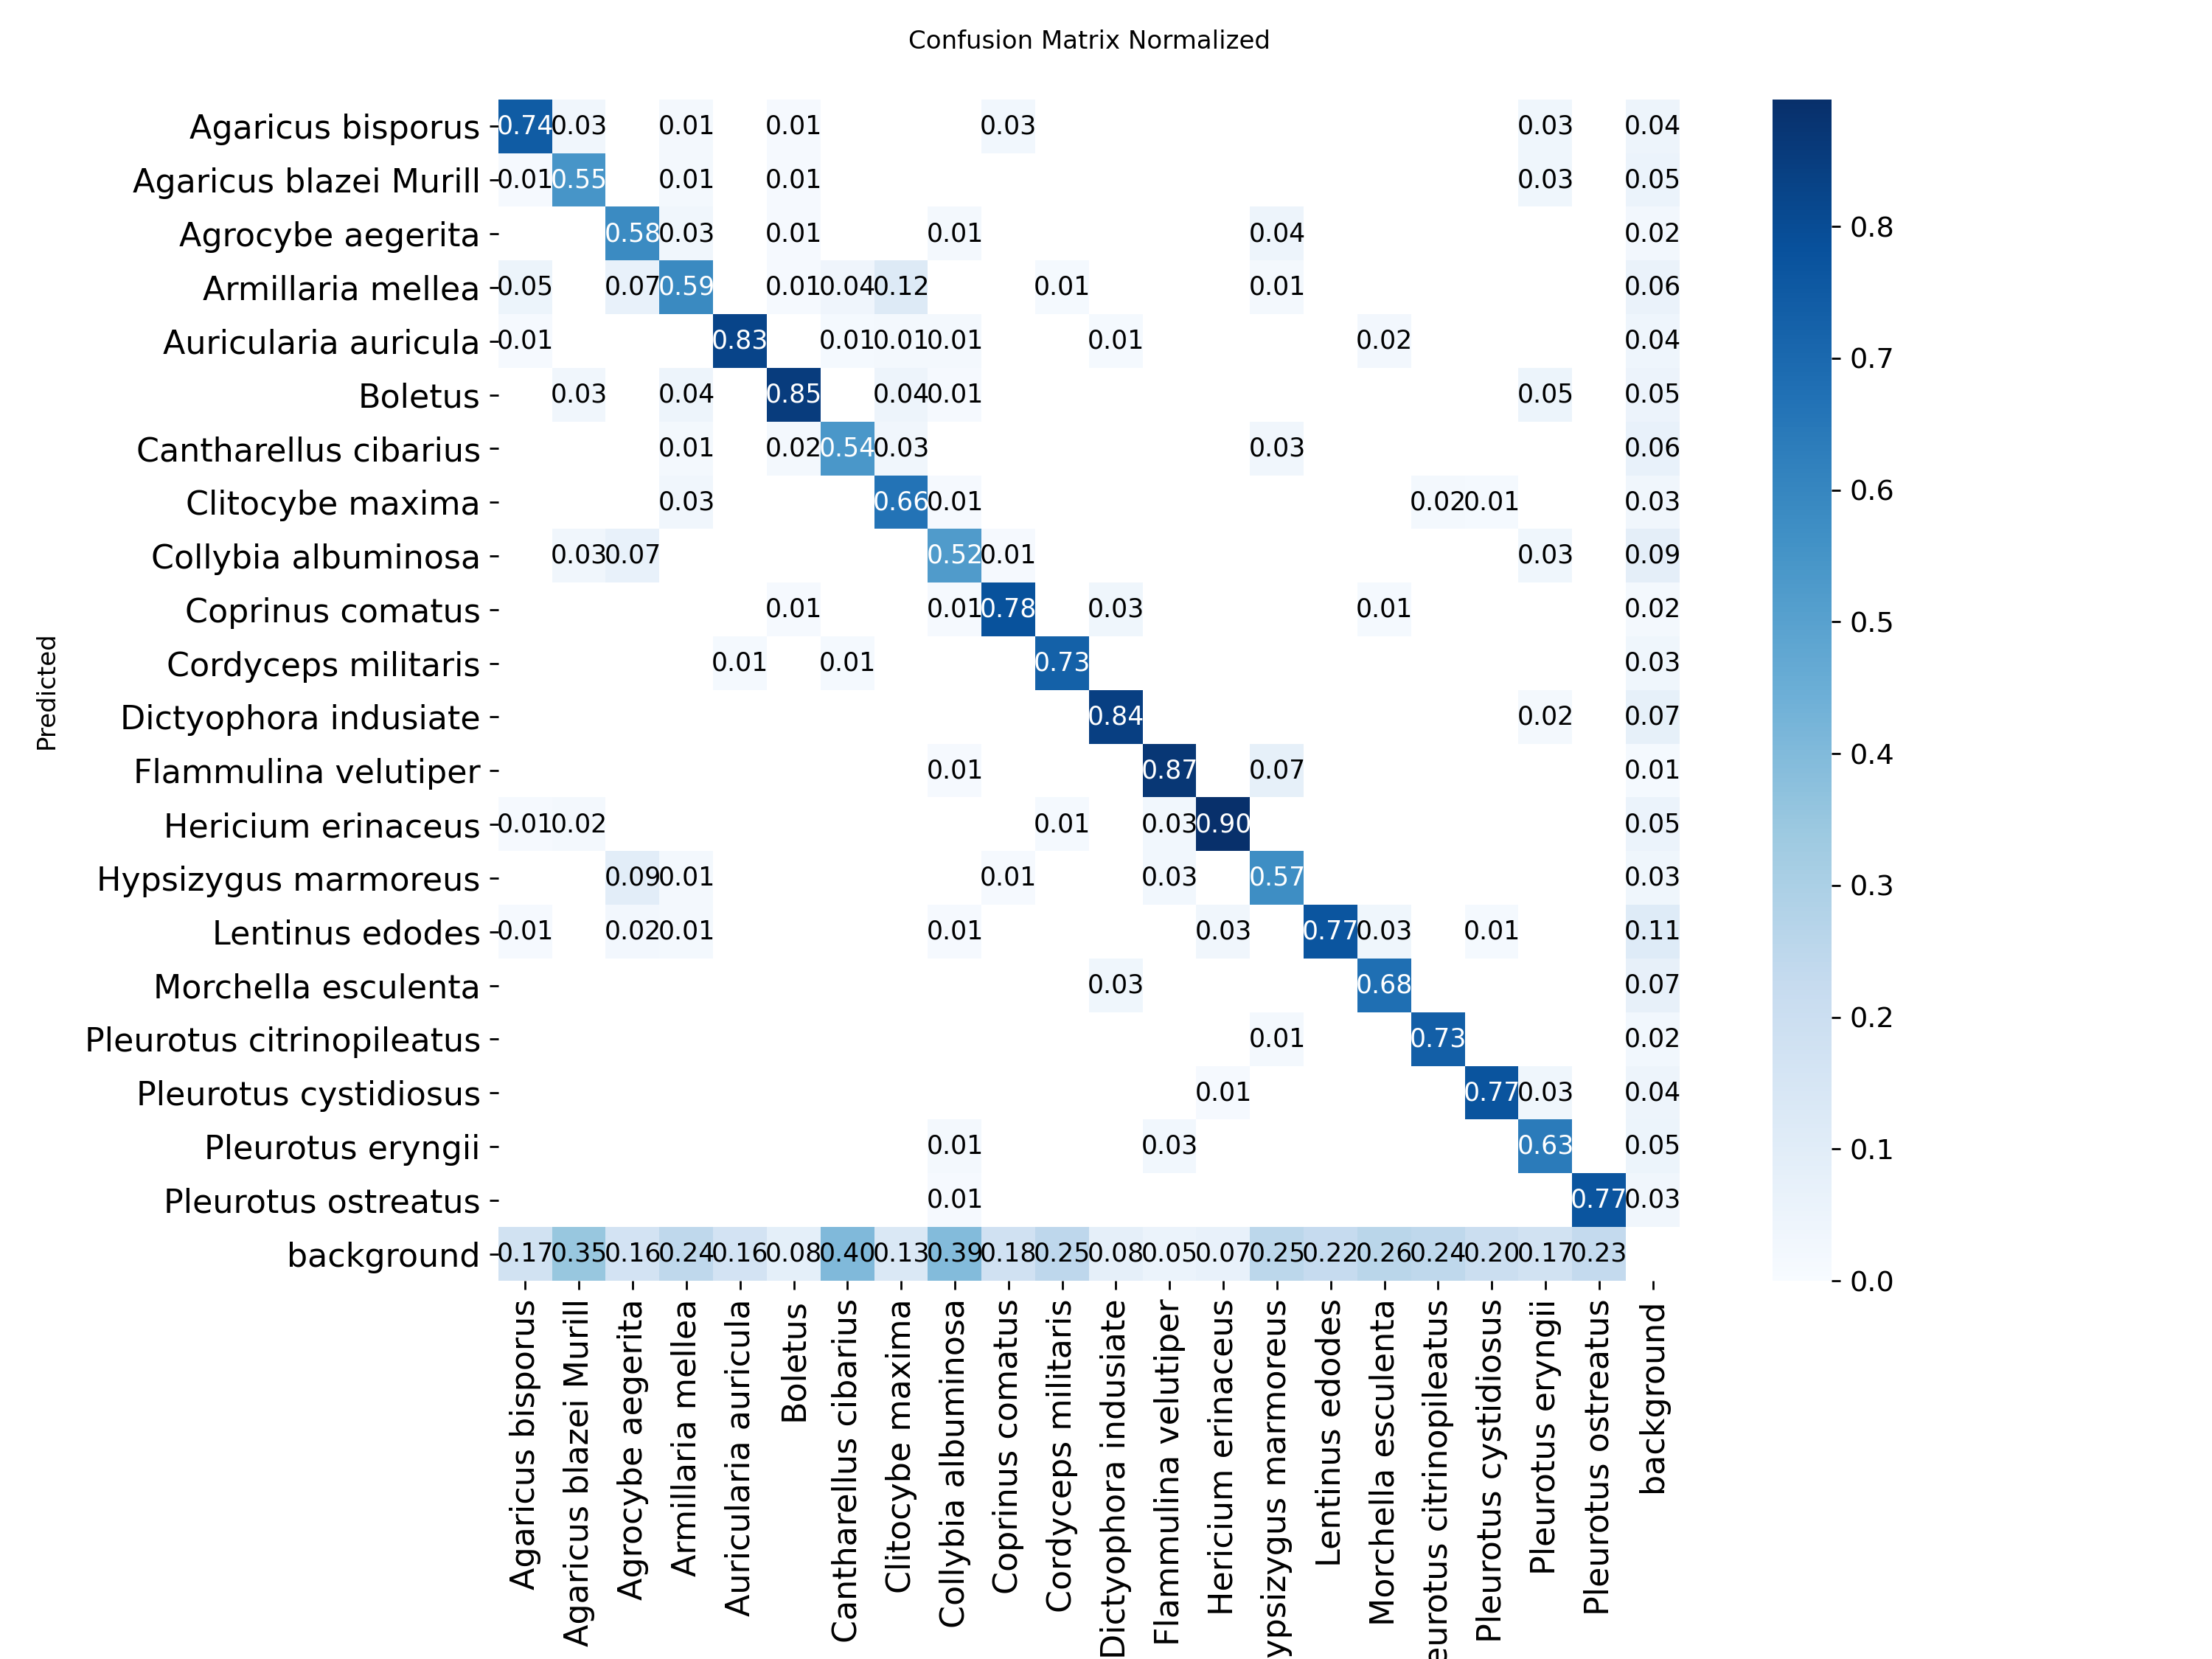

In [ ]:
%matplotlib inline
from PIL import Image

Image.open('C:/Users/User/Desktop/val4/confusion_matrix_normalized.png')

# Test

Testing with test set from dataset

In [ ]:
results = model.val(data='config.yaml', split='test')

print(f"mAP50-95: {results.box.map:.3f}")
print(f"mAP50:    {results.box.map50:.3f}")
print(f"Precision:{results.box.mp:.3f}")
print(f"Recall:   {results.box.mr:.3f}")


Ultralytics 8.3.223  Python-3.11.0 torch-2.10.0.dev20251021+cu128 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
Model summary (fused): 72 layers, 11,133,711 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 11.29.4 MB/s, size: 48.4 KB)
val: Scanning C:\Users\User\Desktop\Mushrooms-yolov5.v1i.yolov8\test\labels... 827 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 827/827 1.0Kit/s 0.8s
val: New cache created: C:\Users\User\Desktop\Mushrooms-yolov5.v1i.yolov8\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 52/52 11.1it/s 4.7s
                   all        827       1838       0.72      0.694      0.736      0.585
     Agaricus bisporus         33         79      0.456      0.826      0.671      0.555
Agaricus blazei Murill         28         57       0.62      0.719      0.727      0.572
     Agrocybe aegerita         37         38      0.836       0.94      0.894      0.

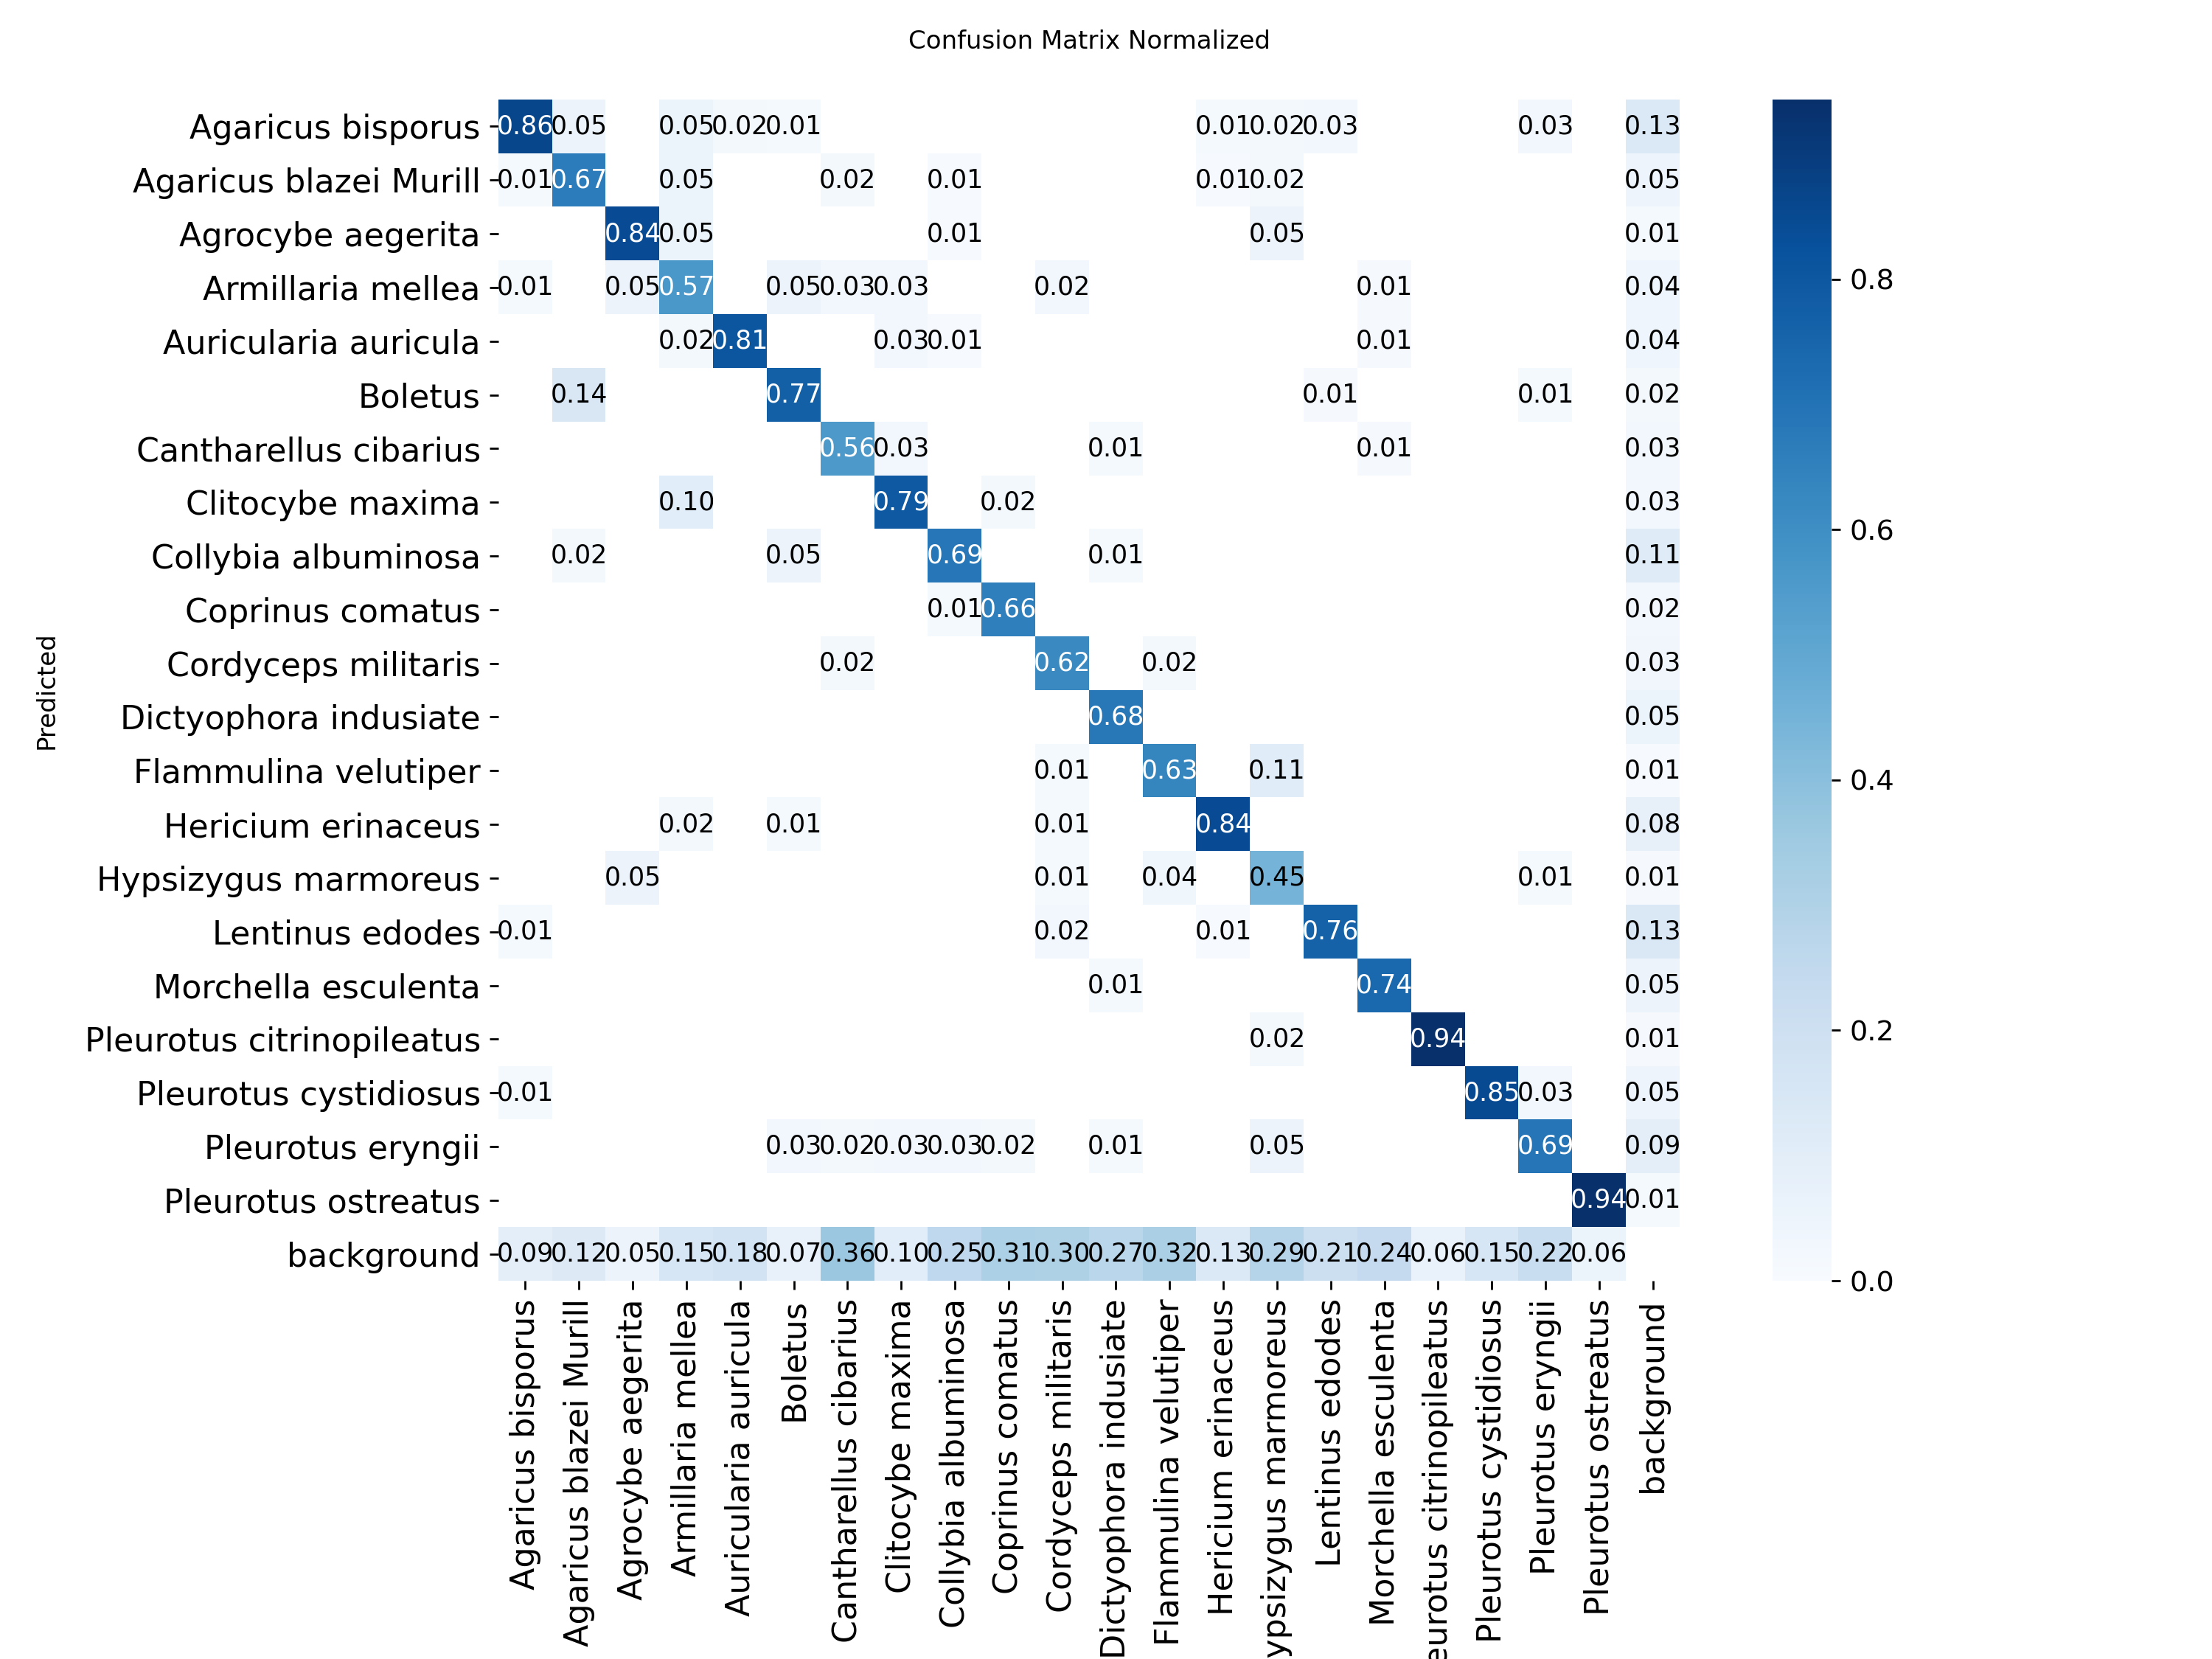

In [6]:
%matplotlib inline
from PIL import Image

Image.open('C:/Users/User/Desktop/confusion_matrix_normalized_test.png')

# Test(custom 60 images)

Test the model using 60 imagess collected by the group

In [ ]:
results_custom = model.val(data='config.yaml', split='test2')

print(f"Custom60 mAP50-95: {results_custom.box.map:.3f}")
print(f"Custom60 mAP50:    {results_custom.box.map50:.3f}")
print(f"Custom60 Precision:{results_custom.box.mp:.3f}")
print(f"Custom60 Recall:   {results_custom.box.mr:.3f}")

Ultralytics 8.3.223  Python-3.11.0 torch-2.10.0.dev20251021+cu128 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
val: Fast image access  (ping: 0.00.0 ms, read: 631.3105.3 MB/s, size: 42.6 KB)
val: Scanning C:\Users\User\Desktop\Mushrooms-yolov5.v1i.yolov8\test_customer\labels.cache... 63 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 63/63  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 2.3it/s 1.8s
                   all         63        177      0.624      0.519      0.589      0.489
     Agaricus bisporus          3         10        0.8        0.9      0.924      0.906
Agaricus blazei Murill          3         13          1      0.615      0.819      0.753
     Agrocybe aegerita          3         25          0          0          0          0
     Armillaria mellea          3         20          0          0    0.00333   0.000998
  Auricularia auricula          3          7      0.538      0.286      0.476

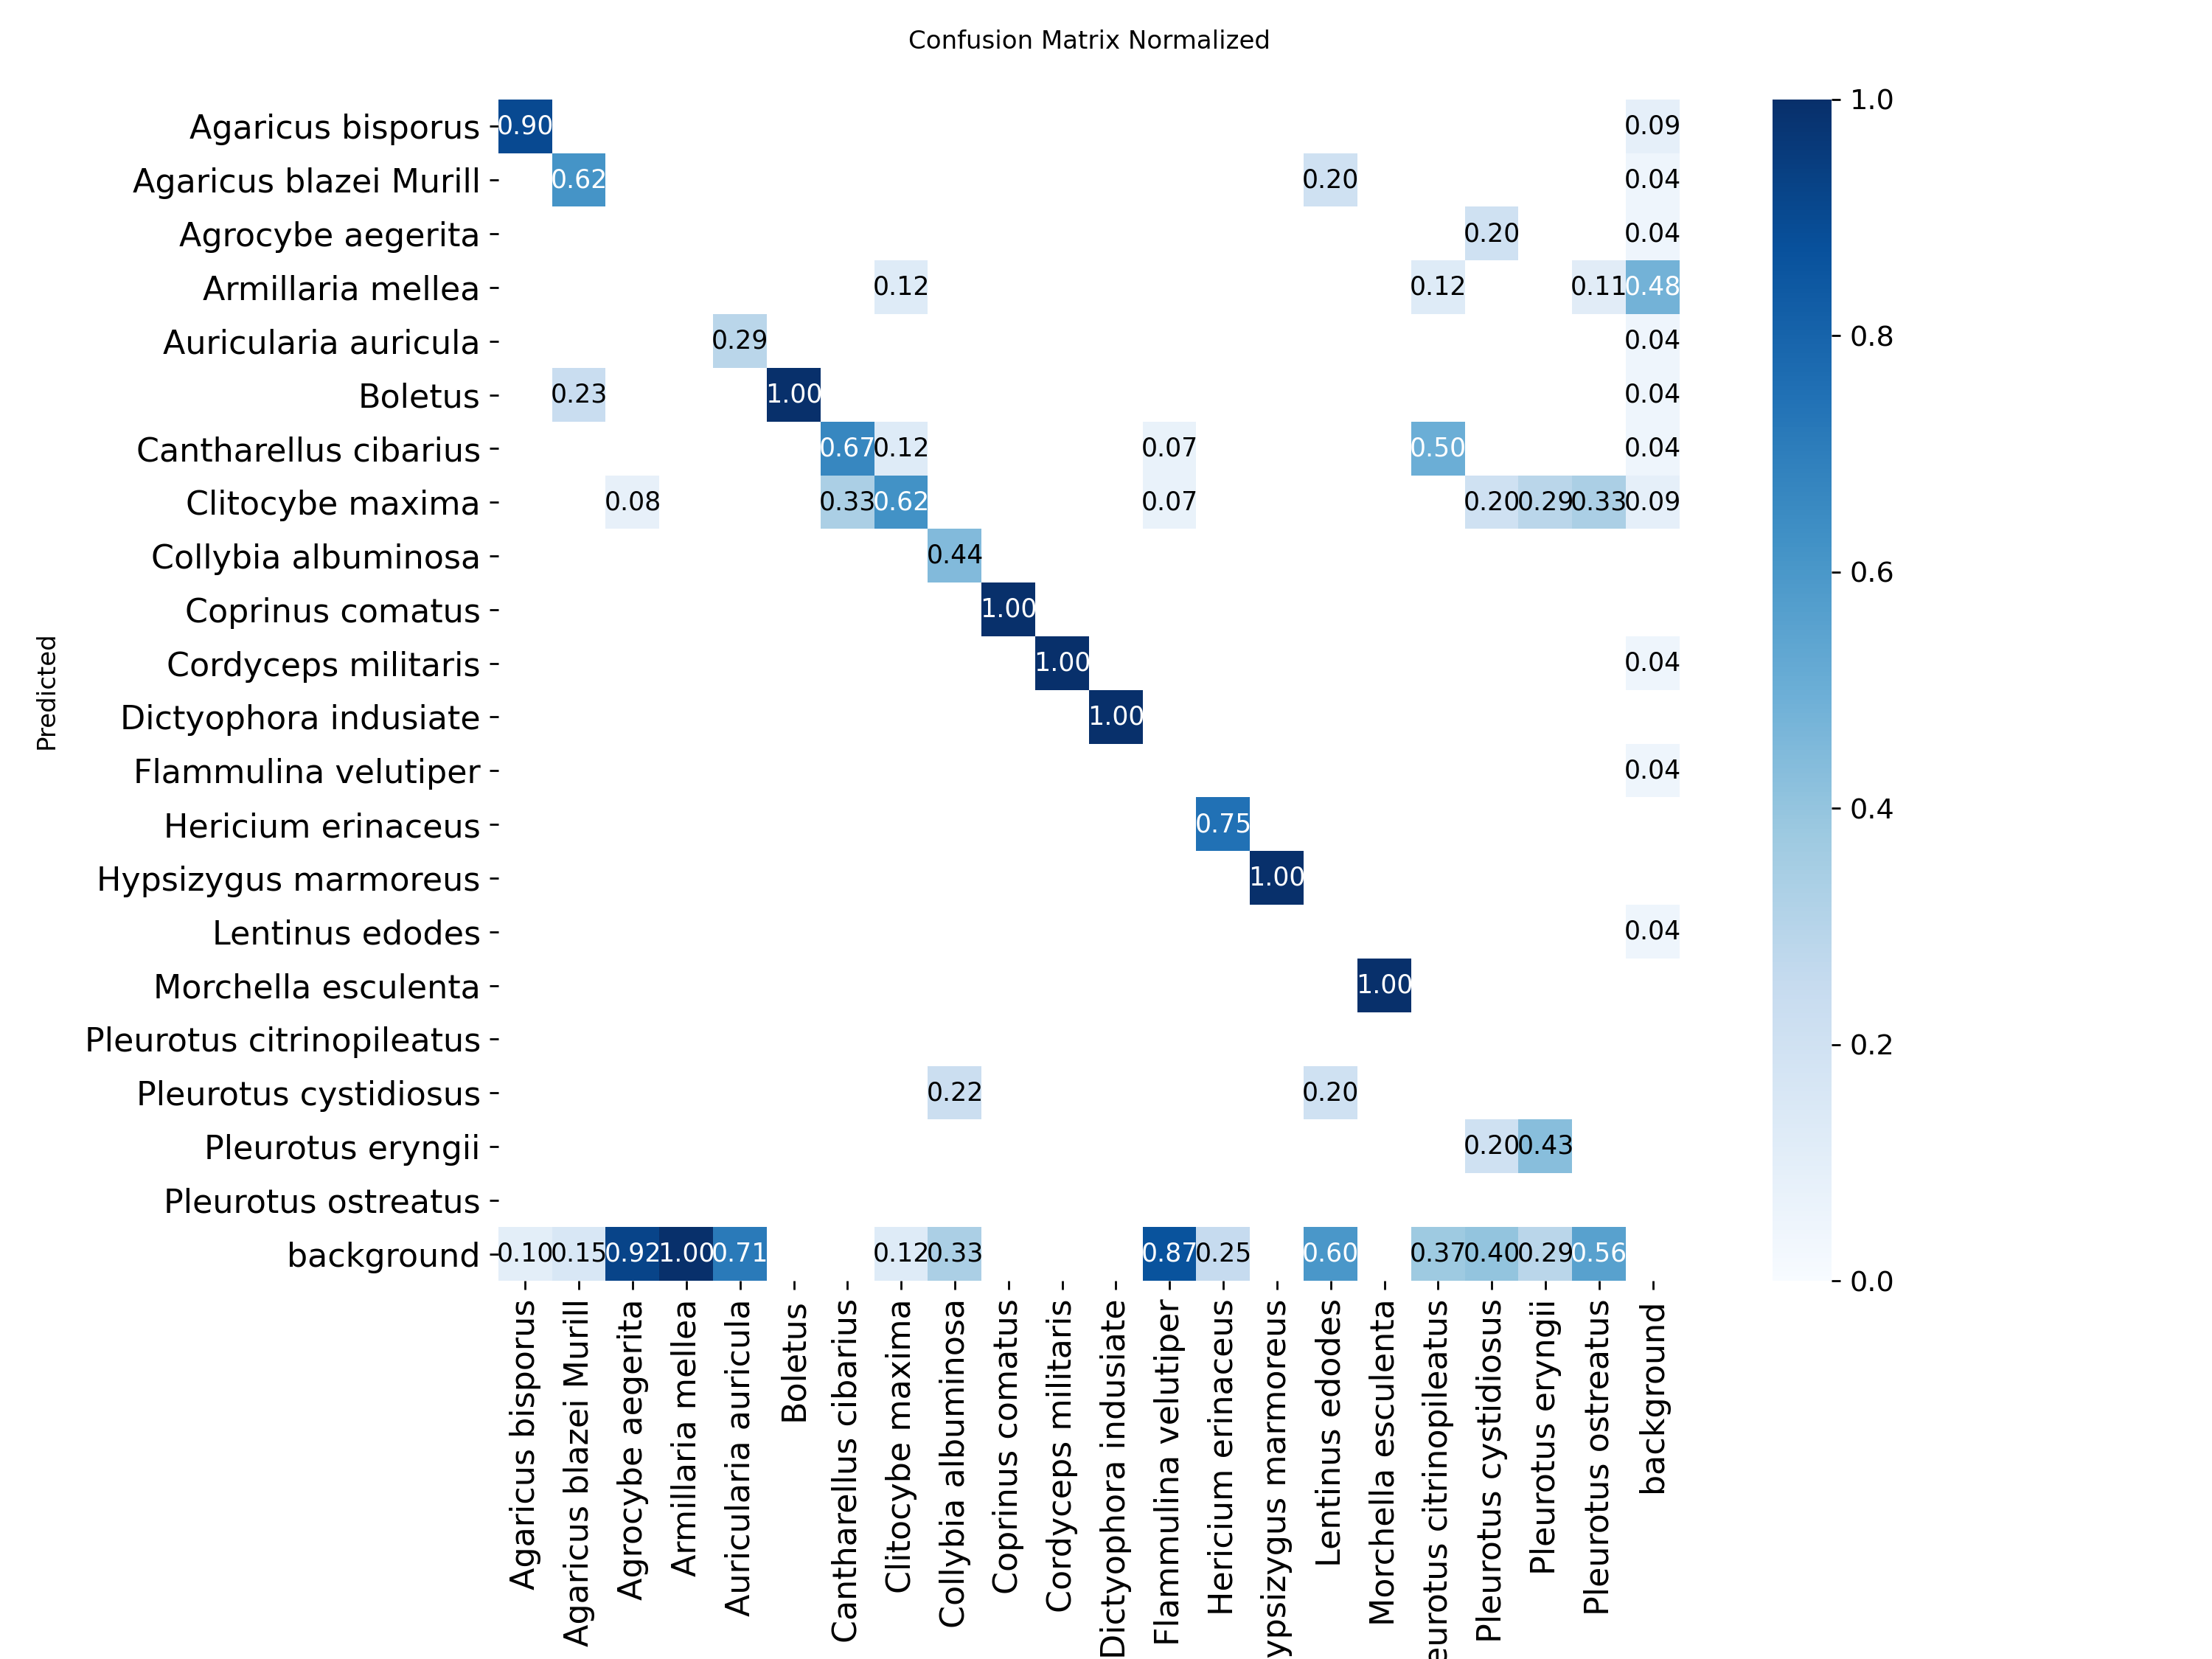

In [7]:
Image.open('C:/Users/User/Desktop/confusion_matrix_normalized_ctest.png')